# A posteriori error estimates for linear elliptic problems in PorePy

<font size="4">
Let $\Omega = (0,1)^2$. The model problem reads
$$
\begin{alignat}{2}
\nabla \cdot \mathbf{u} &= f, \qquad&&\mathrm{in}\,\Omega, \\
\mathbf{u} &= - K \nabla p, \qquad&&\mathrm{in}\,\Omega, \\
p &= 0, \qquad&&\mathrm{on}\,\partial\Omega,
\end{alignat}
$$
with $K = I$, and $f(x,y) = 2 x (1-x) + 2 y (1 - y)$.

Let $p_h \in H^1_0(\Omega)$ and $\mathbf{u}_h \in H(\mathrm{div},\Omega)$ denote the reconstructed pressure and flux obtained by postprocessing the TPFA solution. The aim is to compute the upper bound
$$
\begin{equation}
|||p-p_h||| \leq ||K^{-1/2}\left(\mathbf{u}_h + K\nabla p_h\right)|| + \frac{C_{F,\Omega}}{c_1} ||f - \nabla\cdot\mathbf{u}_h|| :=  \mathcal{M}(p_h,\mathbf{u}_h;f),
\end{equation}
$$
where $C_{F,\Omega} = \frac{1}{\sqrt{2}\pi}$ and $c_1=1$ for our setup.
</font>

## Import packages and modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mdestimates as mde
import numpy as np
import porepy as pp
import quadpy as qp
import scipy.sparse as sps

## Obtain approximate solution using TPFA

### Create a grid

In [3]:
mesh_size = 0.1
domain = {"xmin": 0.0, "xmax": 1.0, "ymin": 0.0, "ymax": 1.0}
network_2d = pp.FractureNetwork2d(None, None, domain)
mesh_args = {"mesh_size_bound": mesh_size, "mesh_size_frac": mesh_size}

gb = network_2d.mesh(mesh_args)
g = gb.grids_of_dimension(2)[0]
#pp.plot_grid(g, alpha=0.1, plot_2d=True, figsize=(5,5))

### Asign data

In [4]:
# Obtain exact source terms
qp_elements = mde.estimates_utils.get_quadpy_elements(g, g)
int_method = qp.t2.get_good_scheme(3)
def f(x):
    return 2 * x[0] * (1 - x[0]) + 2 * x[1] * (1 - x[1])
integrated_sources = int_method.integrate(f, qp_elements)

# Assing parameters
for g, d in gb:
    bc_faces = g.get_boundary_faces()
    bc_type = bc_faces.size * ["dir"]
    bc = pp.BoundaryCondition(g, bc_faces, bc_type)
    bc_values = np.zeros(g.num_faces)
    
    permeability = pp.SecondOrderTensor(np.ones(g.num_cells))
    
    parameters = {
            "bc": bc,
            "bc_values": bc_values,
            "source": integrated_sources,
            "second_order_tensor": permeability,
            "ambient_dimension": gb.dim_max(),
        }
    
    pp.initialize_data(g, d, "flow", parameters)    

### Discretize and solve

In [5]:
# Assing discretization
for g, d in gb:
    d[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1, "faces": 0}}
    d[pp.DISCRETIZATION] = {
        "pressure": {"diffusion": pp.Mpfa("flow"), "source": pp.ScalarSource("flow")}
    }
    
# Assemble and solve
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
sol = sps.linalg.spsolve(A, b)
assembler.distribute_variable(sol)

#pp.plot_grid(g, d[pp.STATE]["pressure"], plot_2d=True, figsize=(6,5))

## Estimate the errors

In [6]:
# Define exact source term
def f(x, y):
    return 2 * x * (x - 1) + 2 * y * (y - 1)

# First, create the error estimates object
estimates = mde.ErrorEstimate(gb, source_list=[f], poincare_list=[1/(np.sqrt(2)*np.pi)])

# Perform the actual estimation of the error
estimates.estimate_error()

# It is convenient to transfer the errors to d[pp.STATE]
estimates.transfer_error_to_state()

Performing velocity reconstruction...✓
Performing pressure reconstruction...✓
Computing upper bounds...✓


### Retrieve the errors

In [7]:
# Diffusive error
diffusive_error = estimates.get_local_error(g, d, "diffusive_error")

# Residual error
residual_error = estimates.get_local_error(g, d, "residual_error")

# Majorant (total error)
majorant = estimates.get_majorant()

print(f"Diffusive error: {diffusive_error}")
print(f"Residual error: {residual_error}")
print(f"Majorant: {majorant}")

Diffusive error: 0.022165063526313637
Residual error: 0.02272476085160069
Majorant: 0.04488982437791433


### Plot the errors

In [8]:
#pp.plot_grid(g, d[pp.STATE]["diffusive_error"], figsize=(6, 5), plot_2d=True, title="Diffusive error")
#pp.plot_grid(g, d[pp.STATE]["residual_error"], figsize=(6, 5), plot_2d=True, title="Residual error")

### Efficiency index

In [9]:
# We know that p(x, y) = x (1 - x) + y (1 - y)

def dp_dx(x, y):
    return y * (1 - x) * (1 - y) - x * y * (1 - y)
    
def dp_dy(x, y):
    return x * (1 - x) * (1 - y) - x * y * (1 - x)
    
int_method = qp.t2.get_good_scheme(4)

recp = mde.estimates_utils.poly2col(d["estimates"]["recon_p"])

def integrand(x):
    int_x = (dp_dx(x[0], x[1]) - recp[0]) ** 2
    int_y = (dp_dy(x[0], x[1]) - recp[1]) ** 2
    return int_x + int_y

true_error = np.sum(int_method.integrate(integrand, qp_elements)) ** 0.5

print(f"True error: {true_error}")
print(f"Majorant: {majorant}")
print(f"Efficiency index: {majorant/true_error}")

True error: 0.017312040801477736
Majorant: 0.04488982437791433
Efficiency index: 2.592982820031396


### Error vs. computational effort

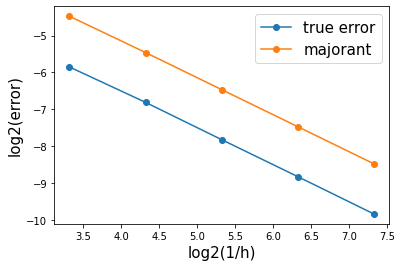

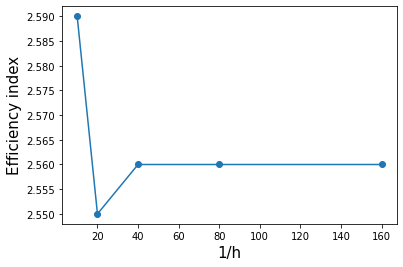

In [10]:
mesh_sizes = np.array([0.1, 0.05, 0.025, 0.0125, 0.00625])
true_errors = np.array([0.0173, 0.00889, 0.00441, 0.00220, 0.00109])
majorants = np.array([0.0449, 0.0227, 0.0113, 0.00563, 0.00280])
efficiency_indices = np.array([2.59, 2.55, 2.56, 2.56, 2.56])

# Error vs 1/h
plt.plot(np.log2(1/mesh_sizes), np.log2(true_errors), marker="o", label="true error")
plt.plot(np.log2(1/mesh_sizes), np.log2(majorants), marker="o", label="majorant")
plt.xlabel("log2(1/h)", fontsize="15")
plt.ylabel("log2(error)", fontsize="15")
plt.legend(fontsize="15")
plt.show()

# Efficiency index vs 1/h
plt.plot(1/mesh_sizes, efficiency_indices, marker="o")
plt.xlabel("1/h", fontsize="15")
plt.ylabel("Efficiency index", fontsize="15")
plt.show()